# Lambda Code to Stop/Start a notebook instance

We will build the following architecture
![Start Stop SageMaker Instances](StartStopSM.png)

In [1]:
import boto3
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)


Let's check the SageMaker API and see how can we find the instances that are running in the account

In [10]:
client = boto3.client('sagemaker')
    
candidates = client.list_notebook_instances()
candidates

{'NotebookInstances': [{'NotebookInstanceName': 'fastai-with-efs',
   'NotebookInstanceArn': 'arn:aws:sagemaker:eu-west-1:217431963147:notebook-instance/fastai-with-efs',
   'NotebookInstanceStatus': 'InService',
   'Url': 'fastai-with-efs.notebook.eu-west-1.sagemaker.aws',
   'InstanceType': 'ml.m4.2xlarge',
   'CreationTime': datetime.datetime(2018, 8, 13, 13, 13, 13, 863000, tzinfo=tzlocal()),
   'LastModifiedTime': datetime.datetime(2018, 8, 24, 10, 46, 41, 550000, tzinfo=tzlocal()),
   'NotebookInstanceLifecycleConfigName': 'MountEFS'}],
 'ResponseMetadata': {'RequestId': '3f8ecced-cad7-40ef-8659-42449daf6de4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3f8ecced-cad7-40ef-8659-42449daf6de4',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '406',
   'date': 'Fri, 24 Aug 2018 15:31:18 GMT'},
  'RetryAttempts': 0}}

We want to find the name of the instance. It is used to send the stop and start commands

In [11]:
for candidate in candidates['NotebookInstances']:
    candidateName = candidate['NotebookInstanceName']

candidateName

'fastai-with-efs'

To discover the tags of the notebook instances we need to know the ARN of each

In [12]:
instanceArn = candidate['NotebookInstanceArn']
instanceTags = client.list_tags(ResourceArn=instanceArn)
instanceTags['Tags']

[{'Key': 'Demo', 'Value': 'fastai'}, {'Key': 'InDuty', 'Value': 'Yes'}]

We will look for a tag with key of 'InDuty' and a value of 'Yes'

In [33]:
for tag in instanceTags['Tags']:
    if (tag['Key'] == 'InDuty' and tag['Value'] =='Yes'):
        print("Found it")

Now we can connect it all together

In [35]:
client = boto3.client('sagemaker')
    
candidates = client.list_notebook_instances()

for candidate in candidates['NotebookInstances']:
    candidateName = candidate['NotebookInstanceName']
    logger.info('instance {0} is in Service'.format(candidateName))
    instanceArn = candidate['NotebookInstanceArn']
    instanceTags = client.list_tags(ResourceArn=instanceArn)
    for tag in instanceTags['Tags']:
        if (tag['Key'] == 'InDuty' and tag['Value'] =='Yes'):
            logger.info('instance {0} is in duty'.format(candidateName))
    #        response = client.stop_notebook_instance(NotebookInstanceName=candidateName)
            logger.info('instance {0} was stopped'.format(candidateName))
        else:
            logger.info('Not in duty'.format(candidateName))


# Creating a lambda function

Using writefile magic command, we will generate the python file to be uploaded to AWS Lambda. Also if you want to append to file you must use -a parameter.

In [2]:
%%writefile lambda_function.py
import boto3
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

client = boto3.client('sagemaker')

def lambda_handler(event, context):
    
    candidates = client.list_notebook_instances()
    
    for candidate in candidates['NotebookInstances']:
        candidateName = candidate['NotebookInstanceName']
        logger.info('instance {0} is in Service'.format(candidateName))
        instanceArn = candidate['NotebookInstanceArn']
        instanceTags = client.list_tags(ResourceArn=instanceArn)
        for tag in instanceTags['Tags']:
            if (tag['Key'] == 'InDuty' and tag['Value'] =='Yes'):
                logger.info('instance {0} is in duty'.format(candidateName))
                if (event['event'] == "On"):
                    response = client.start_notebook_instance(NotebookInstanceName=candidateName)
                    logger.info('instance {0} was started'.format(candidateName))
                elif (event['event'] == "Off"):
                    response = client.stop_notebook_instance(NotebookInstanceName=candidateName)
                    logger.info('instance {0} was stopped'.format(candidateName))
            else:
                logger.info('Not in duty'.format(candidateName))

    return "Done"


Writing lambda_function.py


Adding the lambda function into a zip file (AWS Lambda requires a zip file)

In [4]:
!zip lambda.zip lambda_function.py

  adding: lambda_function.py (deflated 68%)


We can create the bucket and copy the file to it using the awscli or the python SDK. I'll use the aws cli in this example.

In [6]:
!aws s3 mb s3://terraform-serverless-repository --region=eu-west-1

make_bucket: terraform-serverless-repository


Uploading the zip file to the bucket

In [8]:
!aws s3 cp lambda.zip s3://terraform-serverless-repository/v1.0.0/

upload: ./lambda.zip to s3://terraform-serverless-repository/v1.0.0/lambda.zip


With the source code artifact built and uploaded to S3, we can now write our Terraform configuration to deploy it. In a new directory, create a file named lambda.tf containing the following configuration:

In [63]:
%%writefile lambda.tf
provider "aws" {
  region = "eu-west-1"
}

resource "aws_lambda_function" "start_stop_sm" {
  function_name = "StopStartSageMakerNotebookInstances"

  # The bucket name as created earlier with "aws s3api create-bucket"
  s3_bucket = "terraform-serverless-repository"
  s3_key    = "v1.0.0/lambda.zip"

  # "main" is the filename within the zip file (main.js) and "handler"
  # is the name of the property under which the handler function was
  # exported in that file.
  handler = "lambda_function.lambda_handler"
  runtime = "python3.6"

  role = "${aws_iam_role.lambda_exec.arn}"
}

Overwriting lambda.tf


# Creating IAM Role

In [64]:
%%writefile -a lambda.tf
# IAM role which dictates what other AWS services the Lambda function
# may access.
## Testing a working example
resource "aws_iam_role" "lambda_exec" {
    name = "assume-role"
    assume_role_policy = <<EOF
{
    "Version": "2012-10-17",
    "Statement": [
        {
          "Action": "sts:AssumeRole",
          "Principal": {
            "Service": "lambda.amazonaws.com"
          },
          "Effect": "Allow",
          "Sid": ""
        }
      ]
    }
EOF
}

resource "aws_iam_policy" "policy" {
    name        = "control-policy"
    description = "A policy to control SageMaker instances start/stop state"
    policy = <<EOF
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "CloudWatchLogs0",
            "Effect": "Allow",
            "Action": [
                "logs:CreateLogStream",
                "logs:PutLogEvents"
            ],
            "Resource": "arn:aws:logs:eu-west-1:217431963147:log-group:/aws/lambda/*NotebookInstance:*"
        },
        {
            "Sid": "InstanceControl",
            "Effect": "Allow",
            "Action": [
                "sagemaker:ListTags",
                "ec2:ModifyNetworkInterfaceAttribute",
                "sagemaker:DescribeNotebookInstance",
                "ec2:DeleteNetworkInterface",
                "ec2:DescribeSecurityGroups",
                "ec2:CreateNetworkInterface",
                "ec2:DescribeInternetGateways",
                "ec2:DescribeNetworkInterfaces",
                "ec2:DescribeAvailabilityZones",
                "sagemaker:StopNotebookInstance",
                "ec2:DescribeVpcs",
                "sagemaker:StartNotebookInstance",
                "ec2:AttachNetworkInterface",
                "ec2:DescribeSubnets",
                "sagemaker:ListNotebookInstances"
            ],
            "Resource": "*"
        },
        {
            "Sid": "CloudWatchLogs1",
            "Effect": "Allow",
            "Action": "logs:CreateLogGroup",
            "Resource": "arn:aws:logs:eu-west-1:217431963147:*"
        }
    ]
}
EOF
}

resource "aws_iam_role_policy_attachment" "test-attach" {
    role       = "${aws_iam_role.lambda_exec.name}"
    policy_arn = "${aws_iam_policy.policy.arn}"
}

Appending to lambda.tf


## Terraform installation

In [21]:
!wget https://releases.hashicorp.com/terraform/0.11.8/terraform_0.11.8_linux_amd64.zip

--2018-08-24 20:39:29--  https://releases.hashicorp.com/terraform/0.11.8/terraform_0.11.8_linux_amd64.zip
Resolving releases.hashicorp.com (releases.hashicorp.com)... 151.101.17.183, 2a04:4e42:4::439
Connecting to releases.hashicorp.com (releases.hashicorp.com)|151.101.17.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17871447 (17M) [application/zip]
Saving to: ‘terraform_0.11.8_linux_amd64.zip’

terraform_0.11.8_li 100%[===================>]  17.04M  28.3MB/s    in 0.6s    

2018-08-24 20:39:30 (28.3 MB/s) - ‘terraform_0.11.8_linux_amd64.zip’ saved [17871447/17871447]



In [22]:
!unzip terraform_0.11.8_linux_amd64.zip

Archive:  terraform_0.11.8_linux_amd64.zip
  inflating: terraform               


Before you can work with a new configuration directory, it must be initialized using terraform init, which in this case will install the AWS provider:

In [65]:
!./terraform init


Initializing provider plugins...

The following providers do not have any version constraints in configuration,
so the latest version was installed.

To prevent automatic upgrades to new major versions that may contain breaking
changes, it is recommended to add version = "..." constraints to the
corresponding provider blocks in configuration, with the constraint strings
suggested below.

* provider.aws: version = "~> 1.33"

Terraform has been successfully initialized!

You may now begin working with Terraform. Try running "terraform plan" to see
any changes that are required for your infrastructure. All Terraform commands
should now work.

If you ever set or change modules or backend configuration for Terraform,
rerun this command to reinitialize your working directory. If you forget, other
commands will detect it and remind you to do so if necessary.


In [66]:
!./terraform validate

In [67]:
!./terraform plan

Refreshing Terraform state in-memory prior to plan...
The refreshed state will be used to calculate this plan, but will not be
persisted to local or remote state storage.

aws_iam_policy.policy: Refreshing state... (ID: arn:aws:iam::217431963147:policy/control-policy)

------------------------------------------------------------------------

An execution plan has been generated and is shown below.
Resource actions are indicated with the following symbols:
  + create

Terraform will perform the following actions:

  + aws_iam_role.lambda_exec
      id:                    <computed>
      arn:                   <computed>
      assume_role_policy:    "{\n    \"Version\": \"2012-10-17\",\n    \"Statement\": [\n        {\n          \"Action\": \"sts:AssumeRole\",\n          \"Principal\": {\n            \"Service\": \"lambda.amazonaws.com\"\n          },\n          \"Effect\": \"Allow\",\n          \"Sid\": \"\"\n        }\n      ]\n    }\n"
      create_date:           <computed>
      fo

In [68]:
!./terraform apply -input=false -auto-approve

aws_iam_policy.policy: Refreshing state... (ID: arn:aws:iam::217431963147:policy/control-policy)
aws_iam_role.lambda_exec: Creating...
  arn:                   "" => "<computed>"
  assume_role_policy:    "" => "{\n    \"Version\": \"2012-10-17\",\n    \"Statement\": [\n        {\n          \"Action\": \"sts:AssumeRole\",\n          \"Principal\": {\n            \"Service\": \"lambda.amazonaws.com\"\n          },\n          \"Effect\": \"Allow\",\n          \"Sid\": \"\"\n        }\n      ]\n    }\n"
  create_date:           "" => "<computed>"
  force_detach_policies: "" => "false"
  max_session_duration:  "" => "3600"
  name:                  "" => "assume-role"
  path:                  "" => "/"
  unique_id:             "" => "<computed>"
aws_iam_role.lambda_exec: Creation complete after 0s (ID: assume-role)
aws_iam_role_policy_attachment.test-attach: Creating...
  policy_arn: "" => "arn:aws:iam::217431963147:policy/control-policy"
  role:       "" => "assume-role"
aws_lambda_function

In [93]:
!aws lambda list-functions

{
    "Functions": [
        {
            "FunctionName": "StopStartSageMakerNotebookInstances",
            "FunctionArn": "arn:aws:lambda:eu-west-1:217431963147:function:StopStartSageMakerNotebookInstances",
            "Runtime": "python3.6",
            "Role": "arn:aws:iam::217431963147:role/assume-role",
            "Handler": "lambda_function.lambda_handler",
            "CodeSize": 593,
            "Description": "",
            "Timeout": 3,
            "MemorySize": 128,
            "LastModified": "2018-08-25T14:57:42.376+0000",
            "CodeSha256": "dwNSUpqfgdNJLyUQmxEcRTM1IhJwc/Nc0rpUbzYEVn8=",
            "Version": "$LATEST",
            "TracingConfig": {
                "Mode": "PassThrough"
            },
            "RevisionId": "073b272f-2089-48e1-8f71-495563b987aa"
        }
    ]
}


Testing the deployment of the Lambda function with the event format we will use in our CloudWatch event

In [77]:
!aws lambda invoke --function-name StopStartSageMakerNotebookInstances \
    --payload '{"event":"On"}' \
    --invocation-type RequestResponse \
    --log-type Tail /dev/null | jq -r '.LogResult' | base64 --decode

START RequestId: 4e8c3655-a872-11e8-a36c-296fe0514407 Version: $LATEST
[INFO]	2018-08-25T14:22:33.251Z	4e8c3655-a872-11e8-a36c-296fe0514407	Resetting dropped connection: sagemaker.eu-west-1.amazonaws.com
[INFO]	2018-08-25T14:22:33.411Z	4e8c3655-a872-11e8-a36c-296fe0514407	instance fastai-with-efs is in Service
[INFO]	2018-08-25T14:22:33.520Z	4e8c3655-a872-11e8-a36c-296fe0514407	Not in duty
[INFO]	2018-08-25T14:22:33.522Z	4e8c3655-a872-11e8-a36c-296fe0514407	instance fastai-with-efs is in duty
An error occurred (ValidationException) when calling the StartNotebookInstance operation: Status (InService) not in ([Stopped, Failed]). Unable to transition to (Pending) for Notebook Instance (arn:aws:sagemaker:eu-west-1:217431963147:notebook-instance/fastai-with-efs).: ClientError
Traceback (most recent call last):
  File "/var/task/lambda_function.py", line 22, in lambda_handler
    response = client.start_notebook_instance(NotebookInstanceName=candidateName)
  File "/var/runtime/botocore/clien

## Adding CloudWatch events

We will create two CloudWatch events, one for the start of the working day and one for its end. They will run using cron that we will set the schedule of the office that we cover with it. Both events will call the same Lambda function that we defined above, but each will send a different constant event, one with "On" and the other with "Off"

In [91]:
%%writefile cloud_watch.tf
## Based on the location of the instances. This is for Israel where 
## people are working Sunday to Thursday and 5AM GTM is 8AM
resource "aws_cloudwatch_event_rule" "on_duty" {
    name = "on_duty"
    description = "Fires at the beginning of the working day"
    schedule_expression = "cron(0 5 ? * SUN-THU *)"
}

## people are working Sunday to Thursday and 4PM GTM is 7PM
resource "aws_cloudwatch_event_rule" "off_duty" {
    name = "off_duty"
    description = "Fires at the end of the working day"
    schedule_expression = "cron(0 16 ? * SUN-THU *)"
}

resource "aws_cloudwatch_event_target" "on_duty_start_instances" {
    rule = "${aws_cloudwatch_event_rule.on_duty.name}"
    target_id = "start_stop_sm"
    arn = "${aws_lambda_function.start_stop_sm.arn}"
    input = <<DOC
{
  "event": "On"
}
DOC
}

resource "aws_cloudwatch_event_target" "off_duty_start_instances" {
    rule = "${aws_cloudwatch_event_rule.off_duty.name}"
    target_id = "start_stop_sm"
    arn = "${aws_lambda_function.start_stop_sm.arn}"
    input = <<DOC
{
  "event": "Off"
}
DOC
}

resource "aws_lambda_permission" "allow_cloudwatch_to_call_On_duty" {
    statement_id = "AllowExecutionFromCloudWatchOn"
    action = "lambda:InvokeFunction"
    function_name = "${aws_lambda_function.start_stop_sm.function_name}"
    principal = "events.amazonaws.com"
    source_arn = "${aws_cloudwatch_event_rule.on_duty.arn}"
}

resource "aws_lambda_permission" "allow_cloudwatch_to_call_Off_duty" {
    statement_id = "AllowExecutionFromCloudWatchOff"
    action = "lambda:InvokeFunction"
    function_name = "${aws_lambda_function.start_stop_sm.function_name}"
    principal = "events.amazonaws.com"
    source_arn = "${aws_cloudwatch_event_rule.off_duty.arn}"
}

Overwriting cloud_watch.tf


Now we can update our environment with the new configuration using Terraform apply command

In [92]:
!./terraform apply -input=false -auto-approve

aws_iam_policy.policy: Refreshing state... (ID: arn:aws:iam::217431963147:policy/control-policy)
aws_iam_role.lambda_exec: Refreshing state... (ID: assume-role)
aws_cloudwatch_event_rule.on_duty: Refreshing state... (ID: on_duty)
aws_lambda_function.start_stop_sm: Refreshing state... (ID: StopStartSageMakerNotebookInstances)
aws_lambda_permission.allow_cloudwatch_to_call_On_duty: Refreshing state... (ID: AllowExecutionFromCloudWatch)
aws_cloudwatch_event_target.on_duty_start_instances: Refreshing state... (ID: on_duty-start_stop_sm)
aws_iam_role_policy_attachment.test-attach: Refreshing state... (ID: assume-role-20180825141001678900000001)
aws_lambda_permission.allow_cloudwatch_to_call_On_duty: Destroying... (ID: AllowExecutionFromCloudWatch)
aws_cloudwatch_event_rule.off_duty: Creating...
  arn:                 "" => "<computed>"
  description:         "" => "Fires at the end of the working day"
  is_enabled:          "" => "true"
  name:                "" => "off_duty"
  schedule_exp

We can generate automatic Diagram of the environment

In [99]:
!./terraform graph -draw-cycles | dot -Tsvg > graph.svg

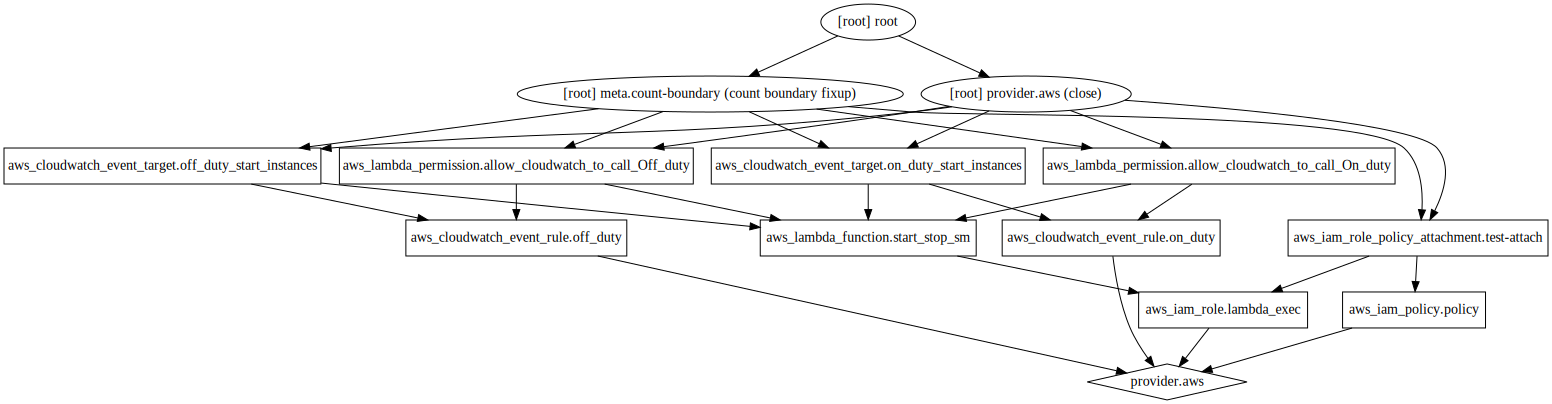

In [100]:
from IPython.core.display import SVG
SVG(filename='graph.svg')

Generating data for LucidChart to generate the visualization of the environment

In [101]:
#!/usr/bin/env python2
import botocore.session
from datetime import datetime, tzinfo, timedelta
import json
from os import environ

#change region to match desired region
region = 'eu-west-1'

class SimpleUtc(tzinfo):
    def tzname(self):
        return "UTC"
    def utcoffset(self, dt):
        return timedelta(0)

class DateTimeEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, datetime):
            return o.utcnow().replace(tzinfo=SimpleUtc()).isoformat()

        return json.JSONEncoder.default(self, o)

def clean_response(resp):
    del resp['ResponseMetadata']
    return resp

output = {}

if 'AWS_PROFILE' in environ:
    session = botocore.session.Session(profile=environ['AWS_PROFILE'])
else:
    session = botocore.session.get_session()

ec2 = session.create_client('ec2', region_name=region)
print("Executing ec2 describe-instances")
output['ec2'] = clean_response(ec2.describe_instances())
print("Executing ec2 describe-security-groups")
output['securitygroup'] = clean_response(ec2.describe_security_groups())
print("Executing ec2 describe-subnet")
output['subnets'] = clean_response(ec2.describe_subnets())
print("Executing ec2 describe-network-acls")
output['acls'] = clean_response(ec2.describe_network_acls())
print("Executing ec2 describe-vpcs")
output['vpc'] = clean_response(ec2.describe_vpcs())
print("Executing ec2 describe-volumes")
output['ebs'] = clean_response(ec2.describe_volumes())
print("Executing elb describe-load-balancers")
output['elb'] = clean_response(session.create_client('elb', region_name=region).describe_load_balancers())
elbv2 = session.create_client('elbv2', region_name=region)
output['elbv2'] = {}
output['elbv2']['TargetHealthDescriptions'] = {}
print("Executing elbv2 describe-load-balancers")
output['elbv2']['LoadBalancers'] = elbv2.describe_load_balancers()['LoadBalancers']
print("Executing elbv2 describe-target-groups")
output['elbv2']['TargetGroups'] = elbv2.describe_target_groups()['TargetGroups']
print("Executing elbv2 describe-target-health")
for target_group_arn in [target_group['TargetGroupArn'] for target_group in output['elbv2']['TargetGroups']]:
    output['elbv2']['TargetHealthDescriptions'][target_group_arn] = elbv2.describe_target_health(TargetGroupArn=target_group_arn)['TargetHealthDescriptions']
print("Executing autoscaling describe-auto-scaling-groups")
output['autoscale'] = clean_response(session.create_client('autoscaling', region_name=region).describe_auto_scaling_groups())
print("Executing autoscaling describe-launch-configurations")
output['launchconfig'] = clean_response(session.create_client('autoscaling', region_name=region).describe_launch_configurations())
print("Executing s3api list-buckets")
output['s3buckets'] = clean_response(session.create_client('s3', region_name=region).list_buckets())
print("Executing rds describe-db-instances")
output['rds'] = clean_response(session.create_client('rds', region_name=region).describe_db_instances())
print("Executing cloudfront describe-db-instances")
output['cloudfront'] = clean_response(session.create_client('cloudfront', region_name=region).list_distributions())

print("Executing sns list-topics")
sns = session.create_client('sns', region_name=region)
topic_resp = sns.list_topics()
print("Executing sns get-topic-attributes")
output['sns'] = [clean_response(sns.get_topic_attributes(TopicArn = t['TopicArn'])) for t in topic_resp.get('Topics',[])]

print("Executing sqs list-queues")
sqs = session.create_client('sqs', region_name=region)
queue_resp = sqs.list_queues()

print("Executing sqs get-queue-attributes")
urls = queue_resp.get('QueueUrls',[])
output['sqs'] = {'Queues': [clean_response(sqs.get_queue_attributes(AttributeNames=['All'], QueueUrl = url)) for url in urls]}

output['importMetaData'] = {'region': region, 'timeStamp': datetime.now()}

with open('aws.json', 'w') as f:
    json.dump(output, f, cls=DateTimeEncoder)

print("Output to aws.json")


Executing ec2 describe-instances
Executing ec2 describe-security-groups
Executing ec2 describe-subnet
Executing ec2 describe-network-acls
Executing ec2 describe-vpcs
Executing ec2 describe-volumes
Executing elb describe-load-balancers
Executing elbv2 describe-load-balancers
Executing elbv2 describe-target-groups
Executing elbv2 describe-target-health
Executing autoscaling describe-auto-scaling-groups
Executing autoscaling describe-launch-configurations
Executing s3api list-buckets
Executing rds describe-db-instances
Executing cloudfront describe-db-instances
Executing sns list-topics
Executing sns get-topic-attributes
Executing sqs list-queues
Executing sqs get-queue-attributes
Output to aws.json
